# Compare parish boundaries with sicbls

We know that Clinical Commissioning Groups (sicbls) and so Sub-Integrated Care Board Locations (SICBLs) are built up from LSOA boundaries. This notebook checks to see if we can build them up from parish boundaries instead.

## Notebook setup

In [1]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_tabular = '../data_tabular/ons_data/'
    dir_tabular = '../data_tabular/'
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_output = 'output_data'
    dir_output_images = 'output_images'

    # Tabular data:
    sicbl_icb = 'LOC22_ICB22_NHSER22_EN_LU.csv'
    lad_country = 'Local_Authority_District_to_Country_(December_2022)_Lookup_in_the_United_Kingdom.csv'
    sicbl_lad = 'LSOA11_LOC22_ICB22_LAD22_EN_LU.csv'

    # Boundaries data:
    parish22_geojson = 'Parishes_and_Non_Civil_Parished_Areas_Dec_2020_EW_BGC_V2_2022.geojson'
    sicbl22_geojson = 'SICBL_JUL_2022_EN_BGC.geojson'

    # Output:
    df_output = 'parish22_sicbl22.csv'
    image_output = 'boundaries_parish22_sicbl22.png'

paths = Paths()

## Import region files

In [4]:
gdf_parish = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.parish22_geojson))
gdf_sicbl = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl22_geojson))

In [5]:
gdf_sicbl.head(3)

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,32649d0f-f9d3-4108-a109-0fea4cd3af00,"POLYGON ((443219.660 409833.090, 443286.853 40..."
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,f8f0102e-9c60-42ef-980d-cb0c67b4b161,"MULTIPOLYGON (((576454.010 184830.650, 576417...."
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,358ec7e7-3a4c-4f5c-b51f-cffa8666f71e,"MULTIPOLYGON (((482031.031 373911.312, 482015...."


In [6]:
gdf_parish.head(3)

,OBJECTID,PARNCP20CD,PARNCP20NM,PARNCP20NW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E04000001,Blackrod,,361020,410662,-2.59036,53.59109,40ab0254-aadf-423d-becb-5d307558c4cf,"POLYGON ((360732.303 412845.704, 360831.499 41..."
1,2,E04000002,Horwich,,365741,411963,-2.51919,53.60311,a73799df-b5aa-445e-9bc7-ec72661680e2,"POLYGON ((366340.404 414544.797, 366110.597 41..."
2,3,E04000003,Westhoughton,,365008,406179,-2.52961,53.55108,cbacc002-a251-49c0-9a72-46402a5f4d8c,"POLYGON ((366943.596 404722.699, 366815.097 40..."


Split any parish MultiPolygon into their Polygons:

In [8]:
gdf_parish = gdf_parish.explode()

/tmp/ipykernel_17643/1263418635.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_parish = gdf_parish.explode()


Find parish centroids:

In [9]:
gdf_parish['centroid'] = gdf_parish['geometry'].centroid

In [10]:
gdf_parish.head(3)

,,OBJECTID,PARNCP20CD,PARNCP20NM,PARNCP20NW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,centroid
0,0,1,E04000001,Blackrod,,361020,410662,-2.59036,53.59109,40ab0254-aadf-423d-becb-5d307558c4cf,"POLYGON ((360732.303 412845.704, 360831.499 41...",POINT (361204.697 410795.666)
1,0,2,E04000002,Horwich,,365741,411963,-2.51919,53.60311,a73799df-b5aa-445e-9bc7-ec72661680e2,"POLYGON ((366340.404 414544.797, 366110.597 41...",POINT (365139.936 411379.388)
2,0,3,E04000003,Westhoughton,,365008,406179,-2.52961,53.55108,cbacc002-a251-49c0-9a72-46402a5f4d8c,"POLYGON ((366943.596 404722.699, 366815.097 40...",POINT (364775.220 406173.006)


Find representative points:

In [11]:
gdf_parish['representative_point'] = gdf_parish['geometry'].representative_point()

In [12]:
gdf_parish.head(3)

,,OBJECTID,PARNCP20CD,PARNCP20NM,PARNCP20NW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,centroid,representative_point
0,0,1,E04000001,Blackrod,,361020,410662,-2.59036,53.59109,40ab0254-aadf-423d-becb-5d307558c4cf,"POLYGON ((360732.303 412845.704, 360831.499 41...",POINT (361204.697 410795.666),POINT (361046.536 410653.401)
1,0,2,E04000002,Horwich,,365741,411963,-2.51919,53.60311,a73799df-b5aa-445e-9bc7-ec72661680e2,"POLYGON ((366340.404 414544.797, 366110.597 41...",POINT (365139.936 411379.388),POINT (365740.679 411962.251)
2,0,3,E04000003,Westhoughton,,365008,406179,-2.52961,53.55108,cbacc002-a251-49c0-9a72-46402a5f4d8c,"POLYGON ((366943.596 404722.699, 366815.097 40...",POINT (364775.220 406173.006),POINT (365042.359 406187.799)


For each parish point, check if each sicbl polygon contains it:

In [14]:
dict_parish_sicbl = {}

for ind in gdf_parish.index:
    series_bool = gdf_sicbl['geometry'].contains(gdf_parish.loc[ind, 'representative_point'])
    
    sicbl_ind = series_bool[series_bool == True].index
    try:
        sicbl_name = gdf_sicbl.loc[sicbl_ind, 'SICBL22CD'].values[0]
        parish_name = gdf_parish.loc[ind, 'PARNCP20CD']
        
        dict_parish_sicbl[parish_name] = sicbl_name
    except IndexError:
        # This parish isn't in any sicbl.
        pass

In [15]:
series_parish_sicbl = pd.Series(dict_parish_sicbl)
series_parish_sicbl.index.name = 'PARNCP20CD'
series_parish_sicbl.name = 'SICBL22CD'

In [16]:
series_parish_sicbl

PARNCP20CD
E04000001    E38000016
E04000002    E38000016
E04000003    E38000016
E04000004    E38000217
E04000005    E38000135
               ...    
E43000272    E38000233
E43000273    E38000249
E43000274    E38000232
E43000275    E38000223
E43000276    E38000225
Name: SICBL22CD, Length: 10685, dtype: object

In [17]:
gdf_parish = pd.merge(
    gdf_parish, series_parish_sicbl,
    left_on='PARNCP20CD', right_index=True, how='right'
)

In [18]:
gdf_parish.head(3)

,,OBJECTID,PARNCP20CD,PARNCP20NM,PARNCP20NW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,centroid,representative_point,SICBL22CD
0,0,1,E04000001,Blackrod,,361020,410662,-2.59036,53.59109,40ab0254-aadf-423d-becb-5d307558c4cf,"POLYGON ((360732.303 412845.704, 360831.499 41...",POINT (361204.697 410795.666),POINT (361046.536 410653.401),E38000016
1,0,2,E04000002,Horwich,,365741,411963,-2.51919,53.60311,a73799df-b5aa-445e-9bc7-ec72661680e2,"POLYGON ((366340.404 414544.797, 366110.597 41...",POINT (365139.936 411379.388),POINT (365740.679 411962.251),E38000016
2,0,3,E04000003,Westhoughton,,365008,406179,-2.52961,53.55108,cbacc002-a251-49c0-9a72-46402a5f4d8c,"POLYGON ((366943.596 404722.699, 366815.097 40...",POINT (364775.220 406173.006),POINT (365042.359 406187.799),E38000016


Assign a colour to each sicbl:

In [19]:
# Assign colour numbers.
# Use 'distance' balance to use as few colours as possible.
gdf_sicbl['adjacent_colours'] = greedy(
    gdf_sicbl, min_distance=1,
    # balance='distance',
    balance='count',
).astype(str)

In [20]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

In [21]:
# Assign these colours to the regions:
gdf_sicbl['colour_str'] = gdf_sicbl['adjacent_colours'].map(colour_map)

In [22]:
gdf_sicbl.head(3)

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry,adjacent_colours,colour_str
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,32649d0f-f9d3-4108-a109-0fea4cd3af00,"POLYGON ((443219.660 409833.090, 443286.853 40...",4,Orchid
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,f8f0102e-9c60-42ef-980d-cb0c67b4b161,"MULTIPOLYGON (((576454.010 184830.650, 576417....",1,Purple
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,358ec7e7-3a4c-4f5c-b51f-cffa8666f71e,"MULTIPOLYGON (((482031.031 373911.312, 482015....",5,Plum


Copy over the colours to the parish data:

In [23]:
colour_series = gdf_sicbl[['SICBL22CD', 'colour_str']]

In [24]:
colour_series

,SICBL22CD,colour_str
0,E38000006,Orchid
1,E38000007,Purple
2,E38000008,Plum
3,E38000014,DarkOrchid
4,E38000015,Orchid
...,...,...
101,E38000258,Indigo
102,E38000259,DarkOrchid
103,E38000260,Purple
104,E38000261,Indigo


In [25]:
gdf_parish = pd.merge(gdf_parish, colour_series, on='SICBL22CD', how='left')

In [26]:
gdf_parish.head(3)

,OBJECTID,PARNCP20CD,PARNCP20NM,PARNCP20NW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,centroid,representative_point,SICBL22CD,colour_str
0,1,E04000001,Blackrod,,361020,410662,-2.59036,53.59109,40ab0254-aadf-423d-becb-5d307558c4cf,"POLYGON ((360732.303 412845.704, 360831.499 41...",POINT (361204.697 410795.666),POINT (361046.536 410653.401),E38000016,MediumOrchid
1,2,E04000002,Horwich,,365741,411963,-2.51919,53.60311,a73799df-b5aa-445e-9bc7-ec72661680e2,"POLYGON ((366340.404 414544.797, 366110.597 41...",POINT (365139.936 411379.388),POINT (365740.679 411962.251),E38000016,MediumOrchid
2,3,E04000003,Westhoughton,,365008,406179,-2.52961,53.55108,cbacc002-a251-49c0-9a72-46402a5f4d8c,"POLYGON ((366943.596 404722.699, 366815.097 40...",POINT (364775.220 406173.006),POINT (365042.359 406187.799),E38000016,MediumOrchid


## Plot map

Make a map where the sicbl boundaries are outlined and the parish boundaries are coloured in according to the sicbl we think each belongs to.

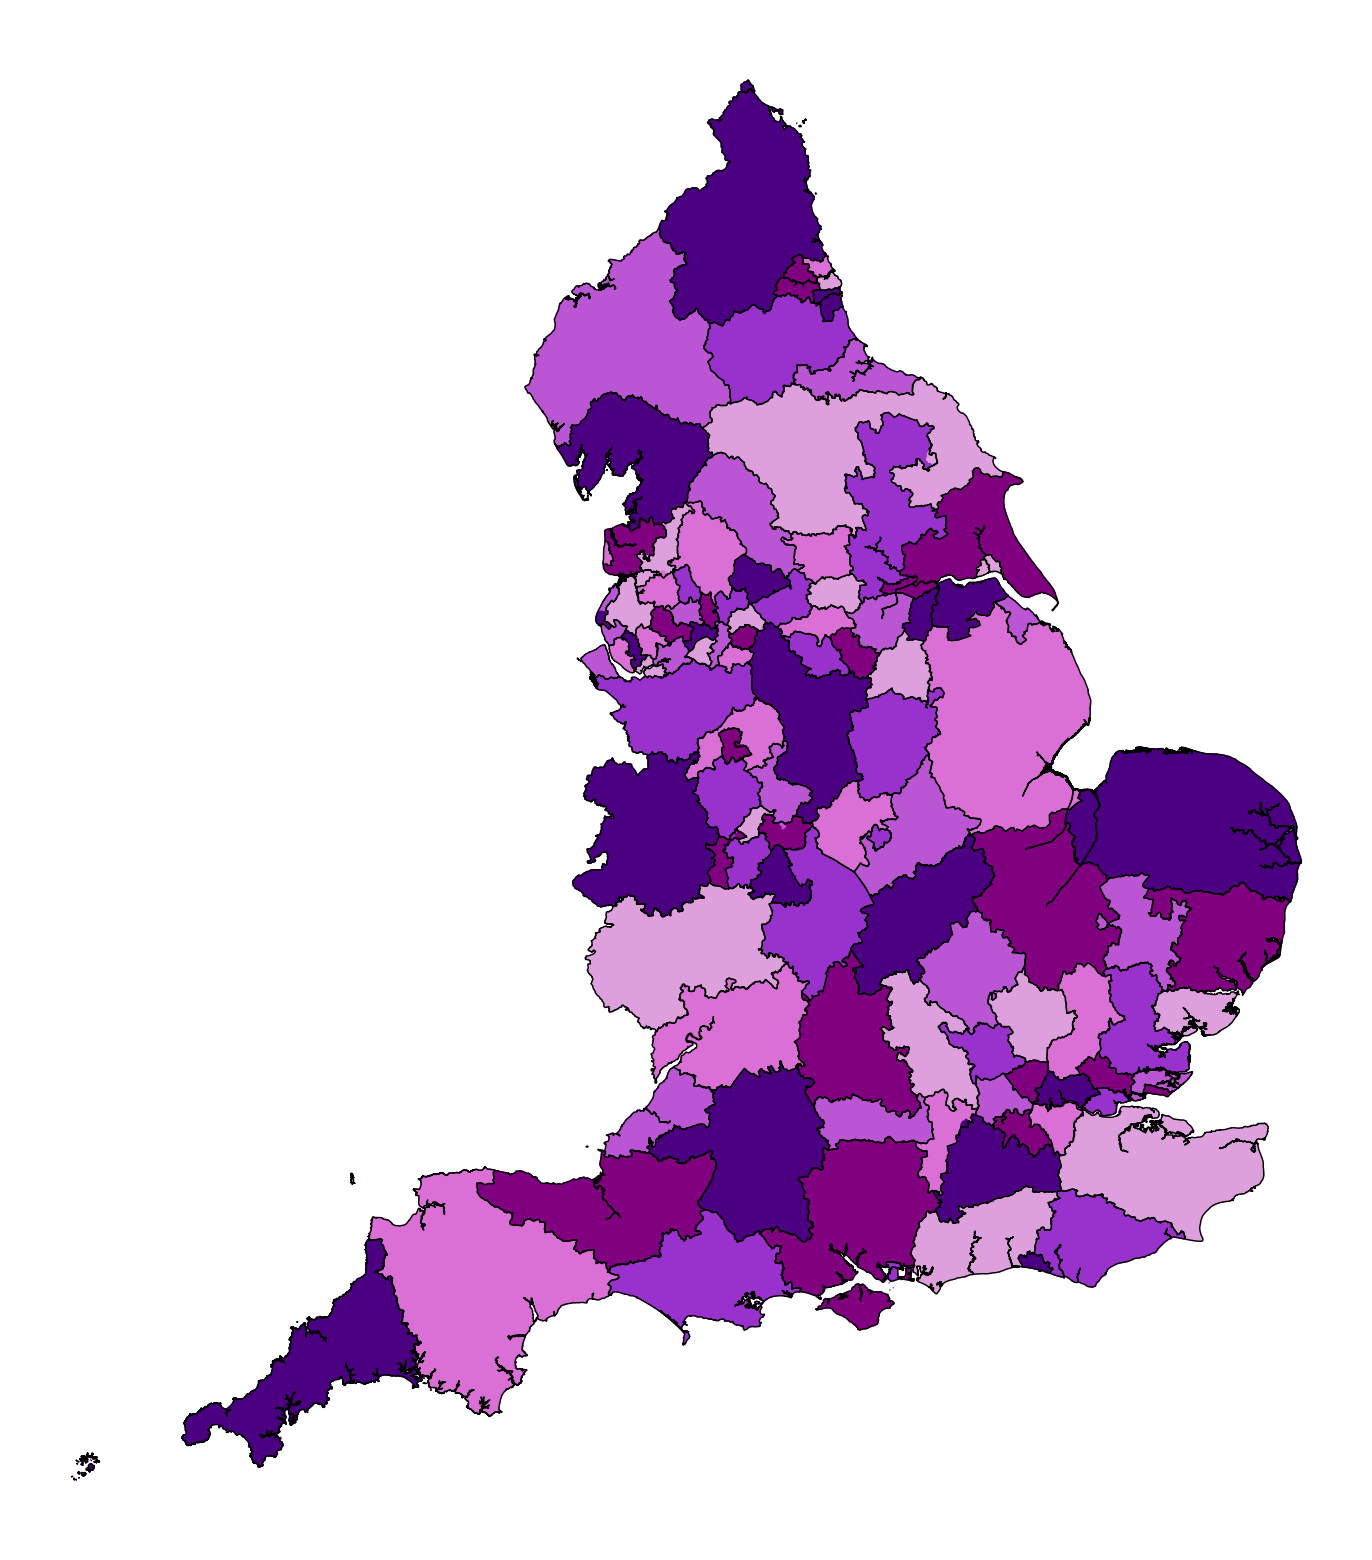

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_parish.plot(ax=ax, edgecolor='face', facecolor=gdf_parish['colour_str'])
gdf_sicbl.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')

plt.savefig(os.path.join(paths.dir_output_images, paths.image_output), bbox_inches='tight')
plt.show()